In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
MENTIONS_COUNTS_FILE = "mentions_counts_by_state_and_months_filtered_5themes.csv"

# External datasets

In [3]:
countries = pd.read_csv("preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3
0,Afghanistan,Asia,AF,AF,AFG
1,Albania,Europe,AL,AL,ALB
2,Algeria,Africa,AG,DZ,DZA
3,American Samoa,Oceania,AQ,AS,ASM
4,Andorra,Europe,AN,AD,AND


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

In [4]:
hdi = pd.read_csv("human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [5]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

In [6]:
epi = pd.read_csv("epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [7]:
epi = epi[["iso", "country", "GDPpc", "PopDensity", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,PopDensity,EPI2018Score
iso,,,,
AFG,Afghanistan,1739.583177,53.083405,37.74
ALB,Albania,11359.099160,104.967190,65.46
DZA,Algeria,13921.176080,17.048895,57.18
AGO,Angola,5984.632947,23.111786,37.44
ATG,Antigua and Barbuda,21013.017630,229.461364,59.18


In [8]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")["FIPS"])
external_data.head(5)

,hdi_2017,country,GDPpc,PopDensity,EPI2018Score,FIPS
ISO3,,,,,,
AFG,0.498,Afghanistan,1739.583177,53.083405,37.74,AF
AGO,0.581,Angola,5984.632947,23.111786,37.44,AO
ALB,0.785,Albania,11359.099160,104.967190,65.46,AL
AND,0.858,NaN,NaN,NaN,NaN,AN
ARE,0.863,United Arab Emirates,67133.014840,110.880526,58.90,AE


# Mentions ratios

In [9]:
mentions_ratios = pd.read_csv(MENTIONS_COUNTS_FILE)
mentions_ratios = mentions_ratios.assign(DATE=pd.to_datetime(mentions_ratios[["YEAR", "MONTH", "DAY"]]))
mentions_ratios.drop(columns=["YEAR", "MONTH", "DAY"], inplace=True)
mentions_ratios.loc[mentions_ratios.ENV_COUNT.isna(), "ENV_COUNT"] = 0
mentions_ratios.sample(10)

,STATE,GLOBAL_COUNT,ENV_COUNT,DATE
222481,EZ,591,2.0,2016-05-30
33521,TD,410,26.0,2017-01-12
104198,MT,290,5.0,2016-09-19
28961,TZ,276,8.0,2015-04-10
148157,LI,555,0.0,2015-09-30
52669,GL,30,17.0,2016-03-28
124635,BC,193,5.0,2015-11-28
162977,AY,17,10.0,2017-09-04
103548,AJ,702,28.0,2015-03-20
45158,RP,11766,69.0,2017-04-12


In [17]:
means = mentions_ratios.groupby("STATE").mean()
means = means[means.ENV_COUNT>5]
means = means.assign(MEAN=means.ENV_COUNT/means.GLOBAL_COUNT)[["MEAN"]]
medians = mentions_ratios.groupby("STATE").median()
medians = medians[medians.ENV_COUNT>5]
medians = medians.assign(MEDIAN=medians.ENV_COUNT/medians.GLOBAL_COUNT)[["MEDIAN"]]

In [18]:
ratios = means.join(medians)
ratios.sample(10)

,MEAN,MEDIAN
STATE,,
BE,0.017070,0.020913
EC,0.073739,0.050459
CD,0.017422,NaN
GP,0.607604,NaN
BF,0.118827,0.017045
MK,0.035237,0.032333
BX,0.030193,0.020370
GA,0.014532,NaN
NZ,0.045995,0.028506


# Join to external datasets

In [19]:
joined = ratios.join(external_data.set_index("FIPS", drop=True), how="left")
joined.head(5)

,MEAN,MEDIAN,hdi_2017,country,GDPpc,PopDensity,EPI2018Score
AC,0.268259,NaN,0.780,Antigua and Barbuda,21013.017630,229.461364,59.18
AE,0.042461,0.027043,0.863,United Arab Emirates,67133.014840,110.880526,58.90
AF,0.050577,0.056752,0.498,Afghanistan,1739.583177,53.083405,37.74
AG,0.116690,0.052478,0.754,Algeria,13921.176080,17.048895,57.18
AJ,0.065115,0.056763,0.757,Azerbaijan,15994.019430,118.097262,62.33


In [20]:
joined.describe()

,MEAN,MEDIAN,hdi_2017,GDPpc,PopDensity,EPI2018Score
count,183.000000,124.000000,163.000000,157.000000,157.000000,157.000000
mean,0.064983,0.035396,0.717564,19072.274493,200.083802,57.203439
std,0.088442,0.028826,0.153284,19913.444747,667.608155,13.111159
min,0.006623,0.004000,0.354000,721.176562,1.948684,27.430000
25%,0.026153,0.020369,0.596500,4854.633154,31.528208,46.920000
50%,0.038349,0.028088,0.747000,13124.319180,80.302846,57.490000
75%,0.062305,0.040192,0.844500,25668.874780,146.850662,65.010000
max,0.649563,0.212121,0.953000,118207.069500,7908.720733,87.420000


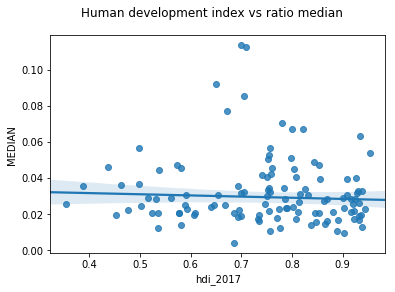

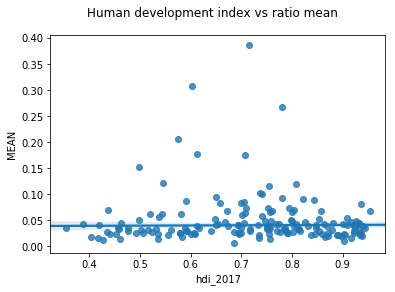

In [21]:
plt.suptitle("Human development index vs ratio median")
sns.regplot("hdi_2017", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("Human development index vs ratio mean")
sns.regplot("hdi_2017", "MEAN", data=joined, robust=True)

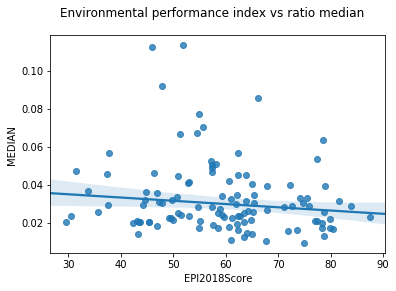

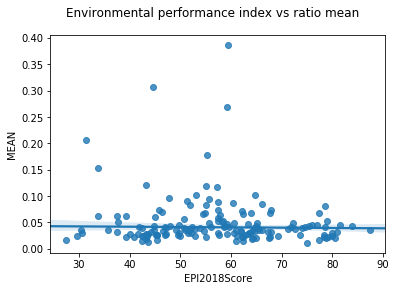

In [22]:
plt.suptitle("Environmental performance index vs ratio median")
sns.regplot("EPI2018Score", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("Environmental performance index vs ratio mean")
sns.regplot("EPI2018Score", "MEAN", data=joined, robust=True)

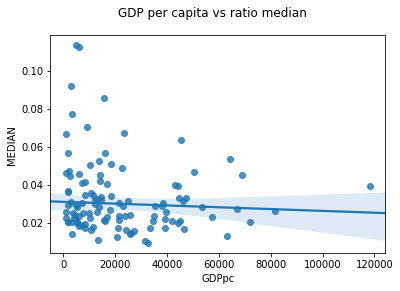

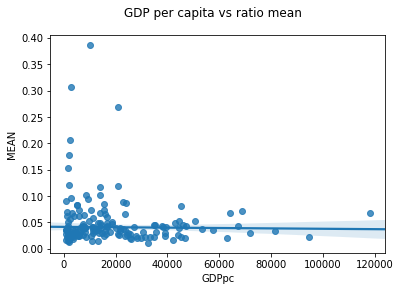

In [23]:
plt.suptitle("GDP per capita vs ratio median")
sns.regplot("GDPpc", "MEDIAN", data=joined, robust=True)

plt.figure()
plt.suptitle("GDP per capita vs ratio mean")
sns.regplot("GDPpc", "MEAN", data=joined, robust=True)